## Abstract ##

In this Kernel we're going to take a look at [*Decision Trees*][1] using *Python* and the Titanic dataset. It's not intended to be the most accurate Titanic survival model out there, but to explain how to create, visualise and understand *Classification Trees*. The main aspects covered are:

 - Learning from the data with *Decision Trees*
 - Dataset exploration and processing
 - Relevant features for *Decision Trees*
 - Gini Impurity
 - Finding best tree depth with the help of cross-validation
 - Generating and visualising the final model

This is my first Kernel, so please feel free to include any suggestions, comments or critics!

[1]: https://en.wikipedia.org/wiki/Decision_tree_learning

Introduction
--------------------

When applying Machine Learning algorithms, it's critical to always keep in mind the problem we're trying to solve. In most cases, the most accurate and robust model might be what you're looking for. But sometimes we need to actually get insights from the available data and in these cases transparent, easy to understand models like *Decision Trees* will greatly simplify our task.

If we need to build a model that will be directly used for some task and **only show it's end results**, then we don't really care about building some kind of "blackbox" if it's accurate enough (image or speech recognition for example). That's why advanced techniques such as [*Deep Learning*][1] or [*Ensemble Learning*][2]  (cf. [Anisotropic Kernel][3]) are commonly used for complex tasks. But remember the KISS principle (Keep It Simple, Stupid)! Always consider the complexity/accuracy trade-off: complex techniques should only be used if they offer significant improvements. Simpler models are also less prone to over-fitting and tend to generalise better.

But if we're using Machine Learning to actually **get insights from the data**, "blackbox" models are almost useless and it's best to stick with simpler, transparent techniques. Let's take the case of a supermarket looking to better understand customer behaviour: the straightforward [*Apriori*][4] algorithm can quickly offer relevant insights like "80% of customers who bought a suit also bought a tie" so they may try to increase tie sales by offering a discount to clients buying a suit . Of course, a complex classification algorithm will do better at identifying the customers who bought a tie by taking into account more features, but is that really useful for the supermarket?

*Decision Trees* can also help a lot when we need to understanding the data. A good example is the traditional problem of classifying Iris flowers included in the [sklearn documentation][5], were we can learn about the characteristics of each flower type in the resulting tree. Given their transparency and relatively low computational cost, *Decision Trees* are also very useful for exploring your data before applying other algorithms. They're helpful for checking the quality of engineered features and identifying the most relevant ones by visualising the resulting tree.

The main downsides of *Decision Trees* are their tendency to over-fit, their inability to grasp relationships between features, and the use of greedy learning algorithms (not guaranteed to find the global optimal model). Using them in a [*Random Forest*][6] helps mitigate some of this issues.

After this short introduction to *Decision Trees* and their place in Machine Learning, let's see how to apply them for the Titanic challenge. First, we're going to prepare the dataset and discuss the most relevant features. We'll then find the best tree depth to avoid over-fitting, generate the final model, and explain how to visualise the resulting tree.


  [1]: https://en.wikipedia.org/wiki/Deep_learning
  [2]: https://en.wikipedia.org/wiki/Ensemble_learning
  [3]: https://www.kaggle.com/arthurtok/titanic/introduction-to-ensembling-stacking-in-python
  [4]: https://en.wikipedia.org/wiki/Apriori_algorithm
  [5]: http://scikit-learn.org/stable/modules/tree.html
  [6]: https://en.wikipedia.org/wiki/Random_forest

## Preparing the Titanic dataset ##

For the Titanic challenge we need to guess wheter the individuals from the *test* dataset had survived or not. But for our current purpose let's also find out what can the data tell us about the shipwreck with the help of a *Classification Tree*. Let's load the data and get an overview.

In [25]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# Loading the data
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Thanks to this overview we can see that our dataset needs some treatment. The class *Survived* is already in binary format so no additional formatting is necessary, but features like *Name*, *Ticket* or *Cabin* need to be adapted for the problem we're trying to solve, and we can also engineer some new features by merging or regrouping existing ones. There's already extended work on this so we're just using one the best approches out there (credit to [Sina][1], [Anisotropic][2] and also [Megan Risdal][3] for the suggestion of the "Title" feature).


  [1]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier
  [2]: https://www.kaggle.com/arthurtok/titanic/introduction-to-ensembling-stacking-in-python
  [3]: https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic

In [26]:
# Copy original dataset in case we need it later when digging into interesting features
# WARNING: Beware of actually copying the dataframe instead of just referencing it
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [27]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Visualising processed data ##

In [28]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


Our dataset is now much cleaner than before, with only numerical values and potentially meaningful features. Let's now explore the relationship between our variables by plotting the Pearson Correlation between all the attributes in our dataset (credit to [Anisotropic][1] for this beautiful plot):


  [1]: https://www.kaggle.com/arthurtok/titanic/introduction-to-ensembling-stacking-in-python

<AxesSubplot: title={'center': 'Pearson Correlation of Features'}>

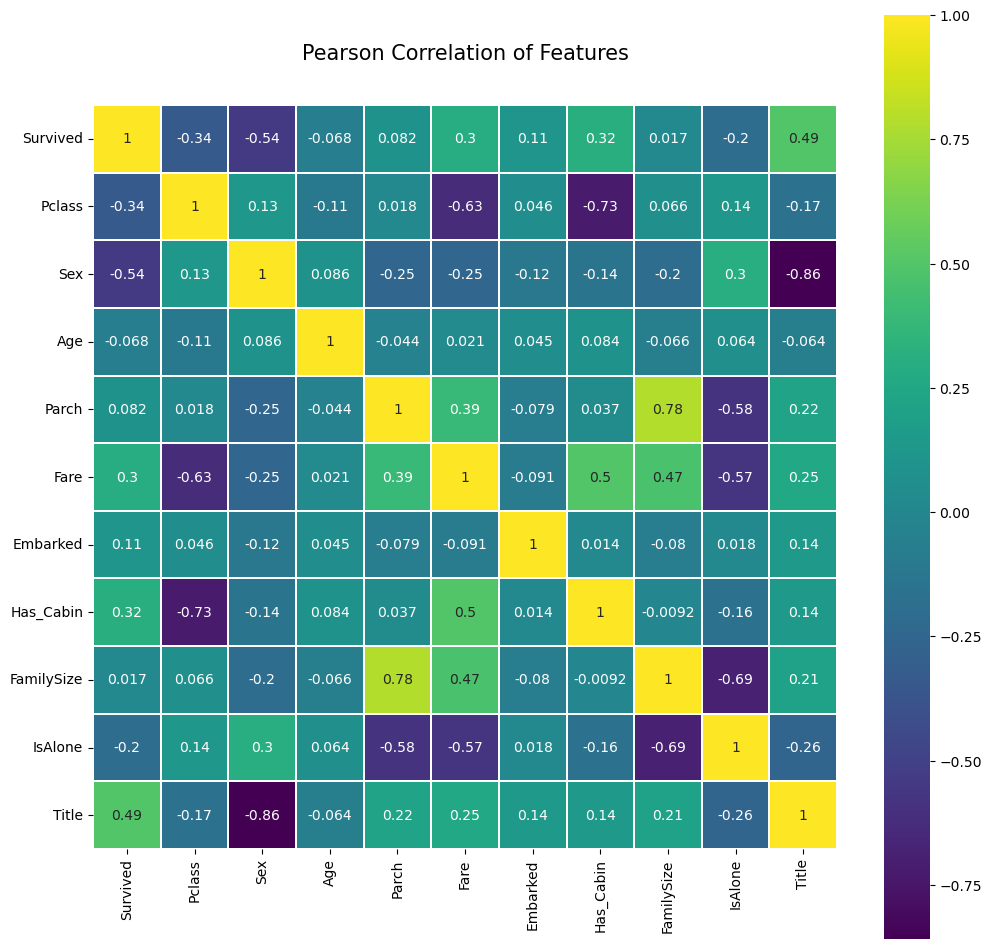

In [44]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

This heatmap is very useful as an initial observation because you can easily get an idea of the predictive value of each feature. In this case, *Sex* and *Title* show the highest correlations (in absolute terms) with the class (*Survived*): 0.54 and 0.49 respectively. But the absolute correlation between both is also very high (0.86, the highest in our dataset), so they are probably carrying the same information and using the two as inputs for the same model wouldn't be a good idea.  High chances are one of them will be used for the first node in our final decision tree, so let's first explore further these features and compare them.

*Title* VS *Sex*
-------

You can easily compare features and their relationship with the class by grouping them and calculating some basic statistics for each group.  The code below does exactly this in one line, and explains the meaning of each metric when working with a binary class.

In [30]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# Since "Survived" is a binary class (0 or 1), these metrics grouped by the Title feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived

# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5} 

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [31]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
# Since Survived is a binary feature, this metrics grouped by the Sex feature represent:
    # MEAN: survival rate
    # COUNT: total observations
    # SUM: people survived
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

The data shows that less 'Mr' survived (15,67%) than men in general (18.89%): *Title* seems therefore to be more useful than *Sex* for our purpose. This may be because *Title* implicitly includes information about *Sex* in most cases. To verify this, we can use the copy we made of the original training data without mappings and check the distribution of *Sex* grouped by *Title*.

In [45]:
# Let's use our 'original_train' dataframe to check the sex distribution for each title.
# We use copy() again to prevent modifications in out original_train dataset
title_and_sex = original_train.copy()[['Name', 'Sex']]

# Create 'Title' feature
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

# Map 'Sex' as binary feature
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Table with 'Sex' distribution grouped by 'Title'
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

# Since Sex is a binary feature, this metrics grouped by the Title feature represent:
    # MEAN: percentage of men
    # COUNT: total observations
    # SUM: number of men

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

We find that, excepting for a single observation (a female with 'Dr' title), all the observations for a given *Title* share the same *Sex*. Therefore the feature *Title* is capturing all the information present in *Sex*. In addition, *Title* may be more valuable to our task by capturing other characteristics of the individuals like age, social class, personality, ...

It's true that by regrouping rare titles into a single category, we are losing some information regarding *Sex*. We could create two categories "Rare Male" and "Rare Female", but the separation will be almost meaningless due to the low occurrence of "Rare" *Titles* (2.6%, 23 out of 891 samples).

Thanks to this in-depth analysis of the *Sex* and *Title* features we've seen that, even if the correlation of the feature *Sex* with the class *Survived* was higher,  *Title* is a richer feature because it carries the *Sex* information but also adds other characteristics. Therefore is very likely that *Title* is going to be the first feature in our final decision tree, making *Sex* useless after this initial split.

## Gini Impurity ##

Before start working with *Decision Trees*, let's briefly explain how they work. The goal of their learning algorithms is always to find the best split for each node of the tree. But measuring the "goodness" of a given split is a subjective question so, in practice, different metrics are used for evaluating splits. One commonly used metric is [Information Gain][1]. The *sklearn* library we're gonna use implements [Gini Impurity][2], another common measure, so let’s explain it.

Gini Impurity measures the disorder of a set of elements. It is calculated as the probability of mislabelling an element assuming that the element is randomly labelled according the the distribution of all the classes in the set. *Decision Trees* will try to find the split which decreases Gini Impurity the most across the two resulting nodes. For the titanic example it can be calculated as follows (code should be explicit enough):


  [1]: https://en.wikipedia.org/wiki/Information_gain_in_decision_trees
  [2]: https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

In [33]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

Let's use our *Sex* and *Title* features as an example and calculate how much each split will decrease the overall weighted Gini Impurity. First, we need to calculate the Gini Impurity of the starting node including all 891 observations in our train dataset. Since only 342 observations survived, the survival probability is around 38,38% (342/891).

In [34]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

We're now going to simulate both splits, calculate the impurity of resulting nodes and then obtain the weighted Gini Impurity after the split to measure how much each split has actually reduced impurity.

If we split by *Sex*, we'll have the two following nodes:

 - Node with men: 577 observations with only 109 survived
 - Node with women: 314 observations with 233 survived

In [35]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [36]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [37]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

If we split by *Title* == 1 (== Mr), we'll have the two following nodes:

 - Node with only Mr: 517 observations with only 81 survived
 - Node with other titles: 374 observations with 261 survived

In [38]:
# Gini Impurity decrease of node for observations with Title == 1 == Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [39]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [40]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

We find that the *Title* feature is slightly better at reducing the Gini Impurity than *Sex*. This confirms our previous analysis, and we're now sure that *Title* will be used for the first split. *Sex* will therefore be neglected since the information is already included in the *Title* feature.  If you want to learn more about how *Decision Trees* work, I recommend you to follow the links in this [Kaggle discussion][3].

  [3]: https://www.kaggle.com/c/titanic/discussion/10169

## Finding best tree depth with the help of Cross Validation ##

After exploring the data, we're going to find of much of it can be relevant for our decision tree. This is a critical point for every Data Science project, since too much train data can easily result in bad model generalisation (accuracy on test/real/unseen observations). Over-fitting (a model excessively adapted to the train data) is a common reason. In other cases, too much data can also hide meaningful relationships either because they evolve with time or because highly correlated features prevent the model from capturing properly the value of each single one.

In the case of decision trees, the 'max_depth' parameter determines the maximum number of attributes the model is going to use for each prediction (up to the number of available features in the dataset).  A good way to find the best value for this parameter is just iterating through all the possible depths and measure the accuracy with a robust method such as [Cross Validation][1].

*Cross Validation* is a model validation technique that splits the training dataset in a given number of "folds". Each split uses different data for training and testing purposes, allowing the model to be trained and tested with different data each time. This allows the algorithm to be trained and tested with all available data across all folds, avoiding any splitting bias and giving a good idea of the generalisation of the chosen model. The main downside is that *Cross Validation* requires the model to be trained for each fold, so the computational cost can be very high for complex models or huge datasets.


  [1]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [41]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.818202
         6          0.807029
         7          0.813745
         8          0.808127
         9          0.815980
        10          0.814856


The best *max_depth* parameter seems therefore to be 3 (82.8% average accuracy across the 10 folds), and feeding the model with more data results in worst results probably due to over-fitting. We'll therefore use 3 as the *max_depth* parameter for our final model.

## Final Tree ##

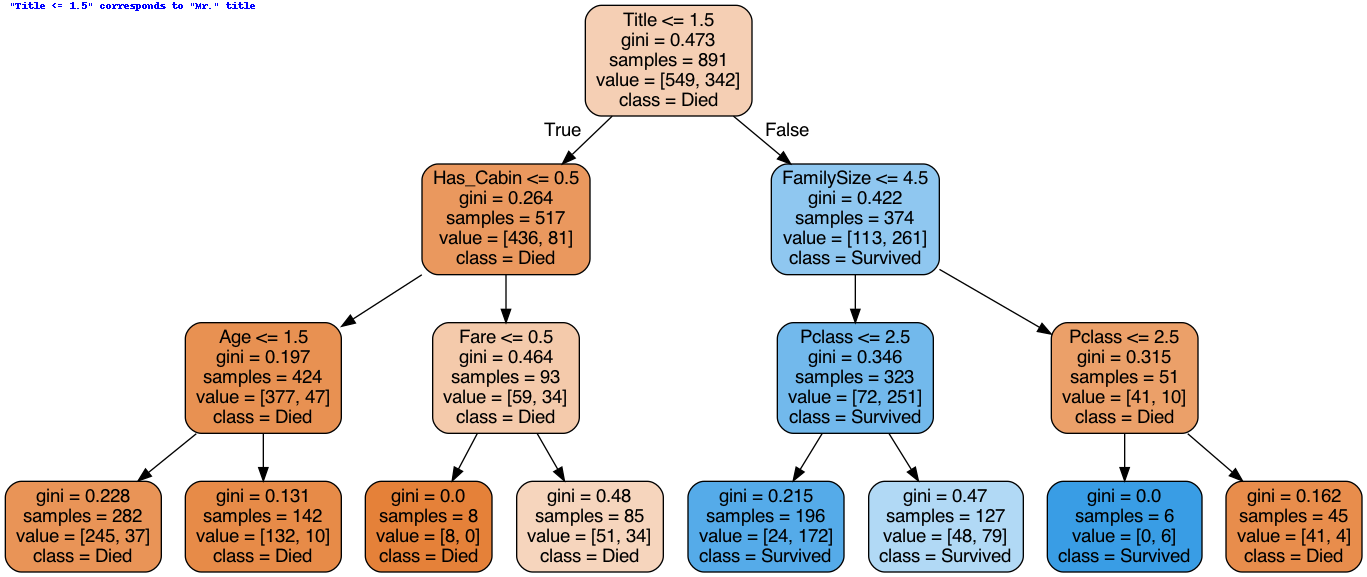

In [42]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255)) # RGB desired color
          #font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

# Code to check available fonts and respective paths
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [46]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

82.38

Finally, here we have our *Decision Tree*! It achieves an accuracy of 82.38% across the training dataset. Let's begin explaining how to read the graph.

The first line of each node (except those of the final row) shows the splitting condition in the form "*feature* <= *value*".

Next, we find the Gini Impurity of the node, already explained in this kernel. "Samples" is simply the number of observations contained in the node.

"Value" shows the class distribution of the samples ([count non_survived, count survived]).

Lastly, "class" correspond to the predominant class of each node, and this is how our model will classify an observation. The colour also represents the class, the opacity increasing with the actual distribution of samples.

Our model can therefore be summarised with 4 simple rules:

 - If our observation includes de "Mr" *Title*, then we classify it as not survived (all the branches in the left side of the tree lead to an orange node)
 - If it doesn't include "Mr" *Title*, and *FamilySize* is 4 or less, then we classify it as survived.
 - If it doesn't include "Mr" *Title*,  *FamilySize* is  more than 4 and *Pclass* is 2 or less, then we classify it as survived.
 - If it doesn't include "Mr" *Title*,  *FamilySize* is  more than 4 and *Pclass* is more than 2, then we classify it as not survived.


Thanks to these rules we can infer some insights about the shipwreck. "Misters" seem to have honoured their title and sacrificed themselves in favour on women and men with more exotic titles like "Master" or "Dr".  We can also note that smaller families had better chances to survive, maybe because bigger families tried to stick together or look for missing members and therefore didn't had places left in the lifeboats. Finally, we can observe that 3rd class passengers had also less chances to survive so probably passengers belonging to upper social social classes were privileged, or simply 3rd class cabins may have been further away of the lifeboats.

Our submission to the Titanic competition results in scoring 2234 out of 5672 competition entries. This result only accounts for part of the submission dataset and is indicative while the competition is running. Not bad for a simple *Decision Tree*!

And remember, any suggestions, comments or critics are welcome!

Thanks for reading,

Diego